# FairGBM example with hyperparameter tuning (using UCI Adult dataset)

**IMPORTANT**: as FairGBM is a research project, the default hyperparameters will not be as reliable as the default `lightgbm` or `sklearn` hyperparameters.

Therefore we earnestly **recommend performing hyperparameter-tuning** on the `fairgbm` hyperparameters, most importantly on the `multiplier_learning_rate` parameter!

This notebook has extra requirements besides `fairgbm`. Simply run ```pip install -r requirements.txt``` to get them!

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
N_TRIALS = 20
N_JOBS = max(2, os.cpu_count())
SEED = 42

PERF_METRIC = "accuracy"
FAIR_METRIC = "equalized_odds_ratio"

### Load data

In [3]:
from utils import load_uci_adult
train_set, other_set = load_uci_adult()
train_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


Split features (X), labels (Y), and sensitive attributes (S).

**NOTE**: the labels (Y) and sensitive attributes (S) must be in numeric format!

In [4]:
UCI_ADULT_TARGET_COL = "target"
UCI_ADULT_SENSITIVE_COL = "sex"

def split_X_Y_S_uci_adult(data) -> tuple:
    """Splits the given UCI Adult data into features, target, and sensitive attributes.
    
    Returns
    -------
    X, Y, S : tuple[pd.DataFrame, pd.Series, pd.Series]
        A tuple conmtaining the dataset's features, labels, and sensitive attributes.
    """
    ignored_cols = [UCI_ADULT_TARGET_COL, UCI_ADULT_SENSITIVE_COL, "fnlwgt"]
    feature_cols = [col for col in data.columns if col not in ignored_cols]

    X = data[feature_cols]
    
    # Convert label to numeric
    Y = np.array(
        [0 if "<=50K" in val.strip() else 1 for val in data[UCI_ADULT_TARGET_COL]],
        dtype=int)

    # Convert sensitive attributes to numeric
    # NOTE! You can use two or more sensitive groups!
    S = np.array(
        [1 if val == "Female" else 0 for val in data[UCI_ADULT_SENSITIVE_COL]],
        dtype=int)
    
    return X, Y, S

In this example we're using only two sensitive attributes (sex="Female" or sex="Male").

However, _FairGBM is **not** restricted to binary sensitive attributes_: you can use two or more as long as they're encoded in a single numeric column.

---
Split test data into validation and test (we need a validation set for hyperparameter tuning).

In [5]:
VALIDATION_SIZE_N = int(0.5 * len(other_set))

indices = np.random.permutation(len(other_set))
val_indices = indices[VALIDATION_SIZE_N: ]
test_indices = indices[: VALIDATION_SIZE_N]

val_set = other_set.iloc[val_indices]
test_set = other_set.iloc[test_indices]

In [6]:
X_train, Y_train, S_train = split_X_Y_S_uci_adult(train_set)
X_val, Y_val, S_val = split_X_Y_S_uci_adult(val_set)
X_test, Y_test, S_test = split_X_Y_S_uci_adult(test_set);

###  Define FairGBM hyperparameter search space and tuner

We're using the [`hyperparameter-tuning`](https://pypi.org/project/hyperparameter-tuning/) package (essentially contains a series of useful wrappers around `optuna`).

In [7]:
# This file contains an example hyperparameter search space for FairGBM
HYPERPARAM_SPACE_PATH = "fairgbm_equalized-odds.yaml"

This tuner configuration will maximize the average of `accuracy` and `equal_odds_ratio`.

In [8]:
from hpt.tuner import ObjectiveFunction, OptunaTuner

obj_func = ObjectiveFunction(
    X_train=X_train, y_train=Y_train, s_train=S_train,
    X_val=X_val, y_val=Y_val, s_val=S_val,
    hyperparameter_space=HYPERPARAM_SPACE_PATH,
    eval_metric=PERF_METRIC,
    other_eval_metric=FAIR_METRIC,
    threshold=0.50,
    alpha=0.50,   # relative weight of `eval_metric` vs `other_eval_metric`
)

tuner = OptunaTuner(
    objective_function=obj_func,
    direction="maximize",
    seed=SEED,
)

[I 2023-09-22 13:18:25,236] A new study created in memory with name: no-name-f0c88745-490d-4264-9468-c9106a7bb3cb


### Run HPT tuner

In [ ]:
%%time
# Then just run optimize as you would for an optuna.Study object
tuner.optimize(n_trials=N_TRIALS, n_jobs=N_JOBS, show_progress_bar=True)

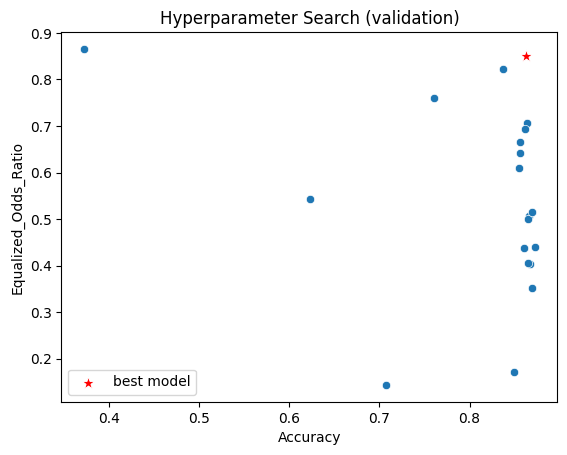

In [10]:
obj_func.plot()

Hyperparameter tuning (HPT) results are stored in `tuner.results`:

In [20]:
# Show results with best fairness
tuner.results.sort_values(by=FAIR_METRIC, ascending=False).head()[
    [PERF_METRIC, FAIR_METRIC, "equalized_odds_diff"]
]

,accuracy,equalized_odds_ratio,equalized_odds_diff
17,0.372313,0.865521,0.105420
13,0.862916,0.849381,0.112689
12,0.836998,0.821629,0.023367
10,0.759980,0.761170,0.017205
6,0.863776,0.706801,0.049897


### Reconstruct classifier from best HPT trial

In [12]:
print(f"Best trial was #{obj_func.best_trial.id}.")

Best trial was #13.


In [13]:
%%time
fairgbm_clf = obj_func.reconstruct_model(obj_func.best_trial)

CPU times: user 3min 19s, sys: 7.47 ms, total: 3min 19s
Wall time: 3min 19s


### Compute test predictions

**Note**: the sensitive attributes are only used in training and not at inference time!

In [14]:
# Compute test predictions (select only probabilities for positive class)
Y_test_pred = fairgbm_clf.predict_proba(X_test)[:, 1]

### And evaluate test performance and fairness

In [15]:
from hpt.evaluation import evaluate_predictions

test_eval = evaluate_predictions(
    y_true=Y_test, y_pred_scores=Y_test_pred,
    sensitive_attribute=S_test,
    threshold=0.50,
)

test_eval

/root/miniconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


{'accuracy': 0.8605651105651105,
 'tpr': 0.6402088772845953,
 'fnr': 0.3597911227154047,
 'fpr': 0.07164658634538153,
 'tnr': 0.9283534136546184,
 'precision': 0.7332535885167464,
 'ppr': 0.20540540540540542,
 'squared_loss': 0.09729872177266831,
 'log_loss': 0.30427899668335334,
 'tnr_ratio': 0.9972660818988818,
 'tnr_diff': 0.002542347647430776,
 'fnr_ratio': 0.9200230149597238,
 'fnr_diff': 0.029159838823315187,
 'precision_ratio': 0.7124308929468922,
 'precision_diff': 0.22543997898607837,
 'fpr_ratio': 0.9649882409696676,
 'fpr_diff': 0.002542347647430776,
 'tpr_ratio': 0.9561213853896781,
 'tpr_diff': 0.029159838823315187,
 'accuracy_ratio': 0.9366861367713762,
 'accuracy_diff': 0.05689994486803318,
 'ppr_ratio': 0.5894314550428764,
 'ppr_diff': 0.09754295770200405,
 'equalized_odds_ratio': 0.9561213853896781,
 'equalized_odds_diff': 0.029159838823315187}

In [16]:
print(f"FairGBM results:")
print(f"\t Accuracy : {test_eval['accuracy']:.1%}")
print(f"\t Equalized odds ratio (higher is better): {test_eval['equalized_odds_ratio']:.1%}")
print(f"\t Equalized odds difference (lower is better): {test_eval['equalized_odds_diff']:.1%}")

FairGBM results:
	 Accuracy : 86.1%
	 Equalized odds ratio (higher is better): 95.6%
	 Equalized odds difference (lower is better): 2.9%
